In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.contrib.tensorboard.plugins import projector

from pylab import rcParams
rcParams['figure.figsize'] = 30,5

num_epoch = 100
batch_size = 50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

data = np.load( "../datasets/shapes_images.npy")
x_tr = data[:10000,in_timesteps]
y_tr = data[:10000,out_timesteps]

x_te = data[10000:,in_timesteps]
y_te = data[10000:,out_timesteps]

tr_set = data[0:10000, :, :, :]
te_set = data[10000:, :, :, :]

print np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te)

(100, 19, 64, 64, 3) (100, 19, 64, 64, 3) (0, 19, 64, 64, 3) (0, 19, 64, 64, 3)


In [2]:
lstm_units = 1024
feature_vector = 1024
latent_dim = 256

# placeholders to hold each frame
x_ = tf.placeholder("float", shape= (None, len(in_timesteps),  64, 64, 3))
y_ = tf.placeholder("float", shape= (None, len(out_timesteps), 64, 64, 3))

# encoder
encoder_conv1_w = tf.get_variable("encoder_conv1_w", shape=[7, 7, 3, 16])
encoder_conv2_w = tf.get_variable("encoder_conv2_w", shape=[5, 5, 16, 32])
encoder_conv3_w = tf.get_variable("encoder_conv3_w", shape=[5, 5, 32, 48])
encoder_conv4_w = tf.get_variable("encoder_conv4_w", shape=[3, 3, 48, 64])

encoder_conv1_b = tf.get_variable("encoder_conv1_b", shape=[16])
encoder_conv2_b = tf.get_variable("encoder_conv2_b", shape=[32])
encoder_conv3_b = tf.get_variable("encoder_conv3_b", shape=[48])
encoder_conv4_b = tf.get_variable("encoder_conv4_b", shape=[64])

def encoder(x):
    out = tf.nn.conv2d(input=x,   filter=encoder_conv1_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv2_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv3_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv4_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv4_b
    out = tf.nn.relu(out)
    out = tf.reshape(out, shape=[-1, 4*4*64])
    return out

# decoder
decoder_conv1_w = tf.get_variable("decoder_conv1_w", shape=[3, 3, 48, 64])
decoder_conv2_w = tf.get_variable("decoder_conv2_w", shape=[5, 5, 32, 48])
decoder_conv3_w = tf.get_variable("decoder_conv3_w", shape=[5, 5, 16, 32])
decoder_conv4_w = tf.get_variable("decoder_conv4_w", shape=[7, 7, 3, 16])

decoder_conv1_b = tf.get_variable("decoder_conv1_b", shape=[48])
decoder_conv2_b = tf.get_variable("decoder_conv2_b", shape=[32])
decoder_conv3_b = tf.get_variable("decoder_conv3_b", shape=[16])
decoder_conv4_b = tf.get_variable("decoder_conv4_b", shape=[3])

def decoder(x):
    out = tf.reshape(x, shape=[-1, 4, 4, 64])
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv1_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 8, 8, 48], padding='SAME') + decoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv2_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 16, 16, 32], padding='SAME') + decoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv3_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 32, 32, 16], padding='SAME') + decoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv4_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 64, 64, 3], padding='SAME') + decoder_conv4_b
    out = tf.nn.sigmoid(out)
    return out

# f_posterior
f_posterior_fc1_w = tf.get_variable("f_posterior_fc1_w", shape=[feature_vector+lstm_units, latent_dim])
f_posterior_fc2_w = tf.get_variable("f_posterior_fc2_w", shape=[latent_dim, latent_dim])

f_posterior_fc1_b = tf.get_variable("f_posterior_fc1_b", shape=[latent_dim])
f_posterior_fc2_b = tf.get_variable("f_posterior_fc2_b", shape=[latent_dim])

f_posterior_mu_w = tf.get_variable("f_posterior_mu_w", shape=[latent_dim, latent_dim])
f_posterior_mu_b = tf.get_variable("f_posterior_mu_b", shape=[latent_dim])

f_posterior_sigma_w = tf.get_variable("f_posterior_sigma_w", shape=[latent_dim, latent_dim])
f_posterior_sigma_b = tf.get_variable("f_posterior_sigma_b", shape=[latent_dim])

def f_posterior(out):
    out = tf.matmul(out, f_posterior_fc1_w) + f_posterior_fc1_b    
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_posterior_fc2_w) + f_posterior_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, f_posterior_mu_w)  + f_posterior_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, f_posterior_sigma_w) + f_posterior_sigma_b)
    
    return out_mu, out_std

# f_decoder
f_decoder_fc1_w = tf.get_variable("f_decoder_fc1_w", shape=[latent_dim+lstm_units, feature_vector])
f_decoder_fc2_w = tf.get_variable("f_decoder_fc2_w", shape=[feature_vector, feature_vector])

f_decoder_fc1_b = tf.get_variable("f_decoder_fc1_b", shape=[feature_vector])
f_decoder_fc2_b = tf.get_variable("f_decoder_fc2_b", shape=[feature_vector])

def f_decoder(out):
    out = tf.matmul(out, f_decoder_fc1_w) + f_decoder_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_decoder_fc2_w) + f_decoder_fc2_b
    out = tf.nn.relu(out)
        
    return out

# f_z
f_z_fc1_w = tf.get_variable("f_z_fc1_w", shape=[latent_dim, latent_dim])
f_z_fc2_w = tf.get_variable("f_z_fc2_w", shape=[latent_dim, latent_dim])

f_z_fc1_b = tf.get_variable("f_z_fc1_b", shape=[latent_dim])
f_z_fc2_b = tf.get_variable("f_z_fc2_b", shape=[latent_dim])

def f_z(out):
    out = tf.matmul(out, f_z_fc1_w) + f_z_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_z_fc2_w) + f_z_fc2_b
    out = tf.nn.relu(out)
    return out

# f_prior
f_prior_fc1_w = tf.get_variable("f_prior_fc1_w", shape=[lstm_units, latent_dim])
f_prior_fc2_w = tf.get_variable("f_prior_fc2_w", shape=[latent_dim, latent_dim])

f_prior_fc1_b = tf.get_variable("f_prior_fc1_b", shape=[latent_dim])
f_prior_fc2_b = tf.get_variable("f_prior_fc2_b", shape=[latent_dim])

f_prior_mu_w = tf.get_variable("f_prior_mu_w", shape=[latent_dim, latent_dim])
f_prior_std_w = tf.get_variable("f_prior_std_w", shape=[latent_dim, latent_dim])

f_prior_mu_b = tf.get_variable("f_prior_mu_b", shape=[latent_dim])
f_prior_std_b = tf.get_variable("f_prior_std_b", shape=[latent_dim])

def f_prior(out):
    out = tf.matmul(out, f_prior_fc1_w) + f_prior_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_prior_fc2_w) + f_prior_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, f_prior_mu_w)  + f_prior_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, f_prior_std_w) + f_prior_std_b)
    
    return out_mu, out_std

def tf_kl_gaussgauss(mu_1, sigma_1, mu_2, sigma_2):
    return tf.reduce_sum(tf.log(sigma_2) - tf.log(sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2*((sigma_2)**2)) - 0.5, axis=1)

def cross_entropy(y_prediction, y):
    prediction_loss = y * tf.log(1e-10 + y_prediction) + (1 - y) * tf.log(1e-10 + 1 - y_prediction)
    return -tf.reduce_sum(prediction_loss, axis=[1, 2, 3])   

def batch_data(source, target, batch_size):

   # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(target)))
    source = source[shuffle_indices]
    target = target[shuffle_indices]

    for batch_i in range(0, len(source)//batch_size):
        start_i = batch_i * batch_size
        source_batch = source[start_i:start_i + batch_size]
        target_batch = target[start_i:start_i + batch_size]

        yield np.array(source_batch), np.array(target_batch)

# lstm
lstm  = tf.nn.rnn_cell.LSTMCell(num_units = lstm_units, state_is_tuple=True)
lstm_state = lstm.zero_state(batch_size, tf.float32)

In [3]:
y_hat_list = []
    
for i in range(0,len(in_timesteps)):
    
    # encode image
    encoder_out = encoder(tf.divide(x=x_[:,i,:,:,:],y=255.0))

    # compute prior
    f_prior_out_mu, f_prior_out_sigma = f_prior(lstm_state[1])
    
    # sample from prior 
    z = f_prior_out_mu + f_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)        
    f_z_out = f_z(z)

    # decode [lstm, latent information]
    f_decoder_out = f_decoder(tf.concat(values=(lstm_state[1], f_z_out), axis=1)) 
    y_hat = decoder(f_decoder_out)
    
    # append output
    y_hat_list.append(y_hat)
    
    # lstm state transition
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(encoder_out, f_z_out), axis=1), state = lstm_state)

for i in range(len(in_timesteps),201):  
    
    # encode image
    encoder_out = encoder(y_hat)

    # compute prior
    f_prior_out_mu, f_prior_out_sigma = f_prior(lstm_state[1])
    
    # sample from prior 
    z = f_prior_out_mu + f_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)        
    f_z_out = f_z(z)

    # decode [lstm, latent information]
    f_decoder_out = f_decoder(tf.concat(values=(lstm_state[1], f_z_out), axis=1)) 
    y_hat = decoder(f_decoder_out)
    
    # append output
    y_hat_list.append(y_hat)
    
    # lstm state transition
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(encoder_out, f_z_out), axis=1), state = lstm_state)

y_hat_out = tf.transpose(tf.stack(y_hat_list), [1, 0, 2, 3, 4])

In [4]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "epoch-100")

INFO:tensorflow:Restoring parameters from epoch-100


# Tests

# Training Set

In [ ]:
y_prediction = sess.run(y_hat_out, feed_dict={x_: x_tr[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
#np.save("mm-into-ms.npy", y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(1,6,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(tr_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(100):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

# Validation Set

In [ ]:
y_prediction = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
#np.save("ms-vrnn-2-shape.npy", y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(1,6,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(100):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

# Generation Diversity

In [ ]:
one = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
two = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
three = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
four = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})

sequence = 9
   
plt.figure()
for i in range(20):
    plt.subplot(1, 20, i+1) 
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(one[sequence,i*5,:,:]) # 19  

plt.figure() 
for i in range(20):
    plt.subplot(1, 20, i+1) 
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(two[sequence,i*5,:,:]) # 19 

plt.figure()    
for i in range(20):
    plt.subplot(1, 20, i+1) 
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(three[sequence,i*5,:,:]) # 19  
    
plt.figure()    
for i in range(20):
    plt.subplot(1, 20, i+1) 
    plt.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off', # labels along the bottom edge are off
    labelleft='off')
    plt.imshow(four[sequence,i*5,:,:]) # 19  

# Out of domain inputs (3 shapes)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 30,5

batch_size = 50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

data = np.load( "../../datasets/moving-shapes-3-len200-images.npy" )

x_te = data[:,in_timesteps]
y_te = data[:,out_timesteps]
te_set = data

print np.shape(x_te), np.shape(y_te)

y_prediction = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
#np.save("ms-vrnn-3-shape.npy", y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(0,10,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(40):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

# Out of domain inputs (1 shapes)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 30,5

batch_size = 50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

data = np.load( "../../datasets/moving-shapes-1-len200-images.npy" )

x_te = data[:,in_timesteps]
y_te = data[:,out_timesteps]
te_set = data

print np.shape(x_te), np.shape(y_te)

y_prediction = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})
print np.shape(y_prediction)
#np.save("ms-vrnn-1-shape.npy", y_prediction)

# Show results
rcParams['figure.figsize'] = 20,5

for sequence in range(10,20,1): # 20,30,5 for training
    
    # ground truth
    fig = plt.figure()
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:])
    plt.savefig(str(sequence) + 'gt.png', bbox_inches='tight')

    rcParams['figure.figsize'] = 18,6
    # prediction
    fig = plt.figure()
    for i in range(40):
        plt.subplot(6, 20, i+1) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:]) # 19   
    plt.savefig(str(sequence) + 'te.png', bbox_inches='tight')

# Latent space analysis

In [8]:
a = np.load( "../../datasets/shapes-1-images.npy" )
b = np.load( "../../datasets/shapes-3-images.npy" )

temp = np.concatenate((x_te[0:25,in_timesteps,:,:,:], x_tr[0:50,in_timesteps,:,:,:]), axis=0)

print np.shape(temp), np.shape(a)

mu = sess.run(phi_prior_mu, feed_dict={x_: temp}) #f_decoder
print np.shape(mu)

(50, 19, 64, 64, 3) (100, 20, 64, 64, 3)
(50, 19, 1024)


In [9]:
timestep = 10

log_dir = os.path.join(os.getcwd(), "tensorboard")
path_to_sprites =  os.path.join(log_dir, 'sprite.png')

# get mu
#mu_list = []
#for i in range(0,1):
    #mu_list = sess.run(phi_prior_mu, feed_dict={x_: x_te[batch_size*i:batch_size+batch_size*i,in_timesteps,:,:,:]})
    #mu_list.append(sess.run(phi_prior_mu, feed_dict={x_: x_tr[batch_size*i:batch_size+batch_size*i,in_timesteps,:,:,:]}))
    #mu_list.append(sess.run(phi_prior_mu, feed_dict={x_: x_tr[0:50,in_timesteps,:,:,:]}))
    
mu = sess.run(f_decoder, feed_dict={x_: temp})  
mu = mu[:,timestep,:]
print np.shape(mu)

#vmu1 = mu[:,5,:]
#mu2 = mu[:,8,:]
#mu = np.concatenate((mu1,mu2),axis=0)
#print np.shape(mu)

(50, 1024)


(50, 64, 64, 3)
512
(512, 512, 3)


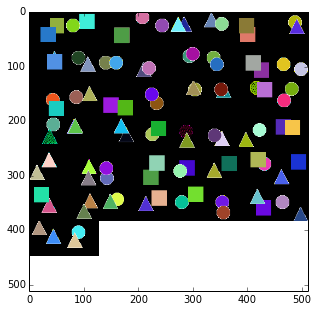

In [10]:
# set embedding variables
#embedding_var = tf.Variable(mu[:,timestep,:], name="mu_0")
embedding_var = tf.Variable(mu, name="mu_0")

# initialize config projector
config = projector.ProjectorConfig()

# add embeddings
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.sprite.image_path = path_to_sprites #'mnistdigits.png'
embedding.sprite.single_image_dim.extend([64,64])

# visualize embeddings
projector.visualize_embeddings(tf.summary.FileWriter(log_dir), config)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.save(sess, os.path.join(log_dir, "model.ckpt"), 1)

def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
        
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots, 3))
    
    print img_h * n_plots
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

#def vector_to_matrix_mnist(mnist_digits):
#    """Reshapes normal mnist digit (batch,28*28) to matrix (batch,28,28)"""
#    return np.reshape(mnist_digits,(-1,28,28))

#def invert_grayscale(mnist_digits):
#    """ Makes black white, and white black """
#    return 1-mnist_digits

#to_visualise = x_tr[0:50,timestep,:,:,:]
to_visualise = temp[:,timestep,:,:,:]
print np.shape(to_visualise)
sprite_image = create_sprite_image(to_visualise)

print np.shape(sprite_image)

plt.imsave(path_to_sprites,sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')
